In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [ ]:
data = pd.read_csv('./train.csv')

data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8000 non-null   int64  
 1   text               8000 non-null   object 
 2   is_humor           8000 non-null   int64  
 3   humor_rating       4932 non-null   float64
 4   humor_controversy  4932 non-null   float64
 5   offense_rating     8000 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 375.1+ KB


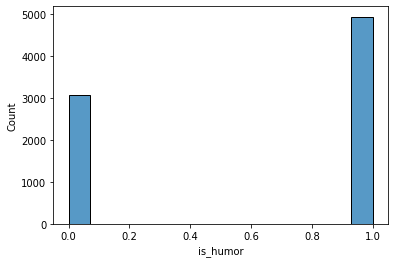

In [ ]:
sns.histplot(data['is_humor'])
plt.show()

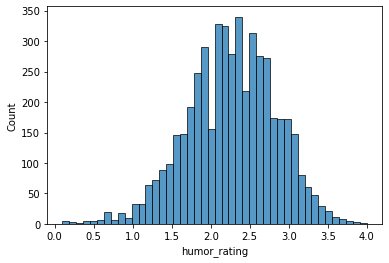

In [ ]:
sns.histplot(data['humor_rating'])
plt.show()

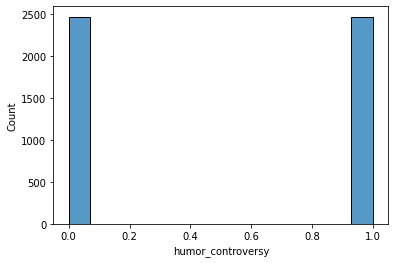

In [ ]:
sns.histplot(data['humor_controversy'])
plt.show()

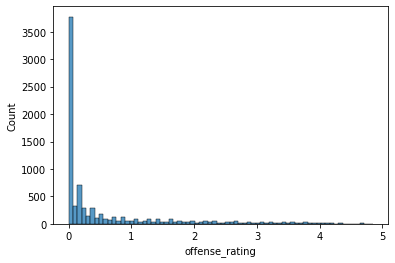

In [ ]:
sns.histplot(data['offense_rating'])
plt.show()

In [ ]:
# https://www.programcreek.com/python/example/99488/nltk.tokenize.treebank.TreebankWordTokenizer

_treebank_word_tokenizer = TreebankWordTokenizer()

def word_tokenize(text, language='english'):
    """
    Return a tokenized copy of *text*,
    using NLTK's recommended word tokenizer
    (currently an improved :class:`.TreebankWordTokenizer`
    along with :class:`.PunktSentenceTokenizer`
    for the specified language).

    :param text: text to split into words
    :type text: str
    :param language: the model name in the Punkt corpus
    :type language: str
    """
    sentences = sent_tokenize(text, language)
    return [
        token for sent in sentences for token in _treebank_word_tokenizer.tokenize(sent)
    ]

# https://github.com/linanqiu/word2vec-sentiments/blob/master/word2vec-sentiment.ipynb

stop_words = set(stopwords.words('english'))

def preprocessForEmbdeddings(corpus):
  sentences = []
  for i, doc in enumerate(corpus):
    doc = doc.lower()
    words = word_tokenize(doc)
    words = [word for word in words if not word in stop_words]
    sent = [words, [i]]
    sentences.append(sent)

  return sentences

def preprocessForTraining(corpus):
  sentences = []
  for doc in corpus:
    doc = doc.lower()
    words = word_tokenize(doc)
    words = [word for word in words if not word in stop_words]
    sentences.append(words)

  return sentences

# is_humor

In [ ]:
# MultinomialNB

for n in range(1, 6):
  # Pre-Processing
  cv = CountVectorizer(stop_words='english', ngram_range=(n,n), tokenizer=word_tokenize)
  text_counts = cv.fit_transform(data['text'])
  X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)
  
  # Modeling
  MNB = MultinomialNB()
  MNB.fit(X_train, y_train)
  predicted = MNB.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{n}-gram Accuracy: {accuracy_score:.4f}')
  print(f'{n}-gram F1-Score: {f1_score:.4f}')
  print()

KeyboardInterrupt: ignored

In [ ]:
# ComplementNB

for n in range(1, 6):
  # Pre-Processing
  cv = CountVectorizer(stop_words='english', ngram_range=(n,n), tokenizer=word_tokenize)
  text_counts = cv.fit_transform(data['text'])
  X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)
  
  # Modeling
  CNB = ComplementNB()
  CNB.fit(X_train, y_train)
  predicted = CNB.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{n}-gram Accuracy: {accuracy_score:.4f}')
  print(f'{n}-gram F1-Score: {f1_score:.4f}')
  print()

In [ ]:
# GaussianNB

# Pre-Processing
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer=word_tokenize)
text_counts = cv.fit_transform(data['text'])
X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)

# Modeling
GNB = GaussianNB()
GNB.fit(X_train.todense(), y_train)
predicted = GNB.predict(X_test.todense())
accuracy_score = metrics.accuracy_score(predicted, y_test)
accuracy_score = metrics.accuracy_score(y_test, predicted)
f1_score = metrics.f1_score(y_test, predicted)
print(f'1-gram Accuracy: {accuracy_score:.4f}')
print(f'1-gram F1-Score: {f1_score:.4f}')

In [ ]:
# BernoulliNB

for n in range(1, 6):
  # Pre-Processing
  cv = CountVectorizer(stop_words='english', ngram_range=(n,n), tokenizer=word_tokenize)
  text_counts = cv.fit_transform(data['text'])
  X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)
  
  # Modeling
  BNB = BernoulliNB()
  BNB.fit(X_train, y_train)
  predicted = BNB.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{n}-gram Accuracy: {accuracy_score:.4f}')
  print(f'{n}-gram F1-Score: {f1_score:.4f}')
  print()

In [ ]:
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)

for model, name in zip((MultinomialNB(), ComplementNB(), BernoulliNB()), ('MNB', 'CNB', 'BNB')):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{name} Accuracy: {accuracy_score:.4f}')
  print(f'{name} F1-Score: {f1_score:.4f}')
  print()

In [ ]:
SGDC = SGDClassifier()
LSVC = LinearSVC()

tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)

LSVC.fit(X_train, y_train)
accuracy_score = metrics.accuracy_score(y_test, LSVC.predict(X_test))
f1_score = metrics.f1_score(y_test, LSVC.predict(X_test))
print(f'LSVC Accuracy (TF-IDF): {accuracy_score:.4f}')
print(f'LSVC F1-Score (TF-IDF): {f1_score:.4f}')
print()

SGDC.fit(X_train, y_train)
accuracy_score = metrics.accuracy_score(y_test, SGDC.predict(X_test))
f1_score = metrics.f1_score(y_test, SGDC.predict(X_test))
print(f'SGDC Accuracy (TF-IDF): {accuracy_score:.4f}')
print(f'SGDC F1-Score (TF-IDF): {f1_score:.4f}')
print()


cv = CountVectorizer(stop_words='english', ngram_range=(n,n), tokenizer=word_tokenize)
text_counts = cv.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(text_counts, data['is_humor'], test_size=0.25, random_state=42)

LSVC.fit(X_train, y_train)
accuracy_score = metrics.accuracy_score(y_test, LSVC.predict(X_test))
f1_score = metrics.f1_score(y_test, LSVC.predict(X_test))
print(f'LSVC Accuracy (CV): {accuracy_score:.4f}')
print(f'LSVC F1-Score (CV): {f1_score:.4f}')
print()

SGDC.fit(X_train, y_train)
accuracy_score = metrics.accuracy_score(y_test, SGDC.predict(X_test))
f1_score = metrics.f1_score(y_test, SGDC.predict(X_test))

print(f'SGDC Accuracy (CV): {accuracy_score:.4f}')
print(f'SGDC F1-Score (CV): {f1_score:.4f}')

In [ ]:
sentences = preprocessForEmbdeddings(data['text'])

model = Doc2Vec(vector_size=100, min_count=1, epochs=30, seed=42)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
sentences = preprocessForTraining(data['text'])

X_train, X_test, y_train, y_test = train_test_split(sentences, data['is_humor'], test_size=0.25, random_state=42)

for i in range(len(X_train)):
  X_train[i] = model.infer_vector(X_train[i])

for i in range(len(X_test)):
  X_test[i] = model.infer_vector(X_test[i])

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(f'LogisticReg Accuracy: {clf.score(X_test, y_test)*100:.2f}%')
print(f'LogisticReg F1-Score: {metrics.f1_score(y_test, clf.predict(X_test)):.4f}')
print()

xgb = XGBClassifier()
xgb.fit(np.array(X_train), np.array(y_train))

print(f'XGB Accuracy: {metrics.accuracy_score(xgb.predict(X_test), y_test)*100:.4f}%')
print(f'XGB F1-Score: {metrics.f1_score(y_test, xgb.predict(X_test)):.4f}')
print()

lgbm = LGBMClassifier(seed=42,
                      feature_fraction=0.8,
                      feature_fraction_bynode=0.8,
                      learning_rate=0.01,
                      n_estimators=1000)
lgbm.fit(np.array(X_train), np.array(y_train))

print(f'LGBM Accuracy: {metrics.accuracy_score(lgbm.predict(X_test), y_test)*100:.2f}%')
print(f'LGBM F1-Score: {metrics.f1_score(y_test, lgbm.predict(X_test)):.4f}')
print()

# cat = CatBoostClassifier(eval_metric='F1', verbose=200)
# cat.fit(np.array(X_train), np.array(y_train))

# print(f'CatBoost Accuracy: {metrics.accuracy_score(cat.predict(X_test), y_test)*100:.2f}%')
# print(f'CatBoost F1-Score: {metrics.f1_score(y_test, cat.predict(X_test)):.4f}')

In [ ]:
X_train = preprocessForTraining(data['text'])
y_train = data['is_humor']

for i in range(len(X_train)):
  X_train[i] = model.infer_vector(X_train[i])

params = {'learning_rate': [0.001, 0.01, 0.1],
          'n_estimators': [100, 250, 500, 1000],
          'feature_fraction': [0.8, 0.9, 1.0],
          'feature_fraction_bynode': [0.8, 0.9, 1.0]}

clf = GridSearchCV(LGBMClassifier(seed=42), param_grid=params)
clf.fit(np.array(X_train), np.array(y_train))

clf.get_params()

In [ ]:
# Training CNB on entire dataset and creating submission
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(data['text'])

CNB = ComplementNB()
CNB.fit(text_counts, data['is_humor'])

test = pd.read_csv('./public_test.csv')
text_counts_test = tfidf.transform(test['text'])

preds = CNB.predict(text_counts_test)
test['is_humor'] = preds

test.to_csv('./is_humor_submission.csv', index=False)

In [ ]:
# Training LGBM on entire dataset and creating submission
sentences = preprocessForTraining(data['text'])

for i in range(len(sentences)):
  sentences[i] = model.infer_vector(sentences[i])

lgbm = LGBMClassifier(seed=42,
                      feature_fraction=0.8,
                      feature_fraction_bynode=0.8,
                      learning_rate=0.01,
                      n_estimators=1000)

lgbm.fit(np.array(sentences), np.array(data['is_humor']))

test = pd.read_csv('./public_test.csv')
sentences = preprocessForTraining(test['text'])

for i in range(len(sentences)):
  sentences[i] = model.infer_vector(sentences[i])

preds = lgbm.predict(np.array(sentences))
test['is_humor'] = preds

test.to_csv('./is_humor_submission-3.csv', index=False)

# humor_rating

In [ ]:
humorous = data.loc[data['is_humor'] == 1]

humorous.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


In [ ]:
sentences = preprocessForEmbdeddings(humorous['text'])

documents = [TaggedDocument(sent[0], sent[1]) for sent in sentences]

model = Doc2Vec(vector_size=200, min_count=1, epochs=40, seed=42)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentences, humorous['humor_rating'], test_size=0.25, random_state=42)

for i in range(len(X_train)):
  X_train[i] = model.infer_vector(X_train[i][0])

for i in range(len(X_test)):
  X_test[i] = model.infer_vector(X_test[i][0])

In [ ]:
xgb = XGBRegressor(random_state=42,
                   colsample_bylevel=0.7,
                   colsample_bytree=0.7,
                   learning_rate=0.1,
                   max_depth=3,
                   reg_alpha=1,
                   reg_lambda=2,
                   objective='reg:squarederror')

xgb.fit(X_train, y_train)
print(f'XGB RMSE: {metrics.mean_squared_error(y_test, xgb.predict(X_test), squared=False)}')

XGB RMSE: 0.5383724140064745


In [ ]:
'''
Performing 5-Fold Cross Validation to find the best vector size for Doc2Vec
'''

kf = KFold(n_splits=5)
kf.get_n_splits(sentences)
xgb = XGBRegressor(random_state=42,
                   colsample_bylevel=0.7,
                   colsample_bytree=0.7,
                   learning_rate=0.1,
                   max_depth=3,
                   reg_alpha=1,
                   reg_lambda=2,
                   objective='reg:squarederror')

for size in [75, 100, 150, 200]:
  for n_epochs in [20, 30, 40, 50]:
    RMSE = []
    X = preprocessForEmbdeddings(humorous['text'])
    y = np.array(humorous['humor_rating'])

    # Train the Doc2Vec model
    documents = [TaggedDocument(sent[0], sent[1]) for sent in X]

    model = Doc2Vec(vector_size=size, min_count=1, epochs=n_epochs, seed=42)
    model.build_vocab(documents)
    model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

    for i in range(len(X)):
      X[i] = model.infer_vector(X[i][0])

    X = np.array(X)

    # 5-Fold CV
    for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      xgb.fit(X_train, y_train)
      RMSE.append(metrics.mean_squared_error(y_test, xgb.predict(X_test), squared=False))

    print(f'Average RMSE (size={size}, epochs={n_epochs}): {sum(RMSE)/len(RMSE)}')

Average RMSE (size=75, epochs=20): 0.5471395678852673
Average RMSE (size=75, epochs=30): 0.5444030208396408
Average RMSE (size=75, epochs=40): 0.544712620312995
Average RMSE (size=75, epochs=50): 0.5434236948147474
Average RMSE (size=100, epochs=20): 0.5466195180937032
Average RMSE (size=100, epochs=30): 0.542664236138487
Average RMSE (size=100, epochs=40): 0.5407638220823916
Average RMSE (size=100, epochs=50): 0.5437764652978829
Average RMSE (size=150, epochs=20): 0.5478456768211311
Average RMSE (size=150, epochs=30): 0.544142667121877
Average RMSE (size=150, epochs=40): 0.5419996693161329
Average RMSE (size=150, epochs=50): 0.5418764711304255
Average RMSE (size=200, epochs=20): 0.5478648574793962
Average RMSE (size=200, epochs=30): 0.5436066972302493
Average RMSE (size=200, epochs=40): 0.5393032883166677
Average RMSE (size=200, epochs=50): 0.5427020606651956


In [ ]:
params = {'learning_rate': [0.001, 0.01, 0.1],
          'max_depth': [3, 4, 5],
          'colsample_bytree': [0.7, 0.8, 0.9],
          'colsample_bylevel': [0.7, 0.8, 0.9],
          'reg_alpha': [0.5, 1, 2],
          'reg_lambda': [1, 2, 4]}

clf = GridSearchCV(XGBRegressor(random_state=42, objective='reg:squarederror'), param_grid=params)
clf.fit(X_train, y_train)

{'num_estimators': 100}

In [ ]:
# Training LGBM on entire dataset and creating submission
sentences = preprocessForTraining(humorous['text'])

for i in range(len(sentences)):
  sentences[i] = model.infer_vector(sentences[i])

xgb = XGBRegressor(random_state=42,
                   colsample_bylevel=0.7,
                   colsample_bytree=0.7,
                   learning_rate=0.1,
                   max_depth=3,
                   reg_alpha=1,
                   reg_lambda=2,
                   objective='reg:squarederror')

xgb.fit(np.array(sentences), np.array(humorous['humor_rating']))

test = pd.read_csv('./public_test.csv')
sentences = preprocessForTraining(test['text'])

for i in range(len(sentences)):
  sentences[i] = model.infer_vector(sentences[i])

preds = xgb.predict(np.array(sentences))
test['humor_rating'] = preds

test.to_csv('./humor_rating.csv', index=False)

# humor_controversy

In [ ]:
sentences = preprocessForEmbdeddings(humorous['text'])

documents = [TaggedDocument(sent[0], sent[1]) for sent in sentences]

model = Doc2Vec(vector_size=100, min_count=1, epochs=30, seed=42)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

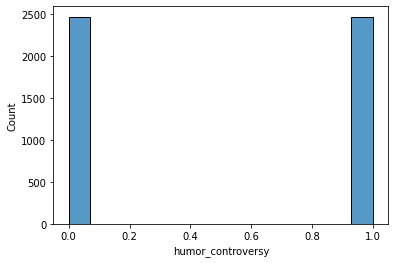

In [ ]:
sns.histplot(humorous['humor_controversy'])

In [ ]:
sentences = preprocessForTraining(humorous['text'])

X_train, X_test, y_train, y_test = train_test_split(sentences, humorous['humor_controversy'], test_size=0.25, random_state=42)

for i in range(len(X_train)):
  X_train[i] = model.infer_vector(X_train[i][0])

for i in range(len(X_test)):
  X_test[i] = model.infer_vector(X_test[i][0])

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(f'LogisticReg Accuracy: {clf.score(X_test, y_test)*100:.2f}%')
print(f'LogisticReg F1-Score: {metrics.f1_score(y_test, clf.predict(X_test)):.4f}')
print()

xgb = XGBClassifier()
xgb.fit(np.array(X_train), np.array(y_train))

print(f'XGB Accuracy: {metrics.accuracy_score(xgb.predict(X_test), y_test)*100:.4f}%')
print(f'XGB F1-Score: {metrics.f1_score(y_test, xgb.predict(X_test)):.4f}')
print()

lgbm = LGBMClassifier()
lgbm.fit(np.array(X_train), np.array(y_train))

print(f'LGBM Accuracy: {metrics.accuracy_score(lgbm.predict(X_test), y_test)*100:.2f}%')
print(f'LGBM F1-Score: {metrics.f1_score(y_test, lgbm.predict(X_test)):.4f}')

LogisticReg Accuracy: 49.55%
LogisticReg F1-Score: 0.4610

XGB Accuracy: 47.7697%
XGB F1-Score: 0.4798

LGBM Accuracy: 49.47%
LGBM F1-Score: 0.5012


In [ ]:
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(humorous['text'])

X_train, X_test, y_train, y_test = train_test_split(text_counts, humorous['humor_controversy'], test_size=0.25, random_state=42)

for model, name in zip((MultinomialNB(), ComplementNB(), BernoulliNB()), ('MNB', 'CNB', 'BNB')):
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, predicted)
  f1_score = metrics.f1_score(y_test, predicted)
  print(f'{name} Accuracy: {accuracy_score:.4f}')
  print(f'{name} F1-Score: {f1_score:.4f}')
  print()

MNB Accuracy: 0.4801
MNB F1-Score: 0.4582

CNB Accuracy: 0.4818
CNB F1-Score: 0.4617

BNB Accuracy: 0.4834
BNB F1-Score: 0.4774



In [ ]:
# Training CNB on entire dataset and creating submission
tfidf = TfidfVectorizer()
text_counts = tfidf.fit_transform(humorous['text'])

CNB = ComplementNB()
CNB.fit(text_counts, humorous['humor_controversy'])

test = pd.read_csv('./public_test.csv')
text_counts_test = tfidf.transform(test['text'])

preds = CNB.predict(text_counts_test)
test['humor_controversy'] = [int(p) for p in preds]

test.to_csv('./humor_controversy_submission.csv', index=False)